In [1]:
# modules import
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Open data

#file path
netCDF_NEMO_file2 = '/Users/jcaillet/Documents/nemo/AMUXL025/ANALYSES/NETCDF/seaice_spatial/Wind/*.nc'
netCDF_NEMO_file3 = '/Users/jcaillet/Documents/nemo/AMUXL025/ANALYSES/NETCDF/seaice_spatial/Ref/*.nc'
netCDF_mask_file = '/Users/jcaillet/Documents/nemo/AMUXL025/OTHERS/isf_mask_AMUXL025_BedMachineAntarctica-2020-07-15_v02.nc'
netCDF_bathy_file = '/Users/jcaillet/Documents/nemo/AMUXL025/OTHERS/bathy_meter_AMUXL025_BedMachineAntarctica-2020-07-15_v02_ICB380.nc'

# general files
# mask file
Mask = xr.open_mfdataset(netCDF_mask_file) 
Mask = Mask.rename_dims({'lat' : 'y', 'lon' : 'x'}) # change lat, lon in x,y
Mask_final = xr.where(Mask.isfmask > 1, 1000, Mask) # 1000 for iceshelves
Mask_final = xr.where(Mask.isfmask < 0, 0, Mask_final) # 0 instead
data1 = np.array(Mask_final['isfmask'].where(Mask.isfmask >1))
data2 = Mask_final.isfmask.where(Mask_final.isfmask==0)
data3 = Mask_final.isfmask
#bathymetry file
bathy = xr.open_mfdataset(netCDF_bathy_file) 
data = np.array(bathy['Bathymetry_isf'])


# wind file
WIND = xr.open_mfdataset(netCDF_NEMO_file2).squeeze()
WIND['x'] = WIND['x'] - WIND['x'] + WIND['nav_lon'][0,:].values
WIND['y'] = WIND['y'] - WIND['y'] + WIND['nav_lat'][:,0].values
REF = xr.open_mfdataset(netCDF_NEMO_file3).squeeze()

WIND_mean = WIND.mean('time_counter')
REF_mean = REF.mean('time_counter')
W = WIND_mean.where(Mask.isfmask!=0)
R = REF_mean.where(Mask.isfmask!=0)
WM = W - R

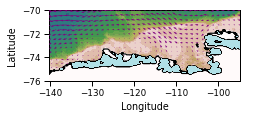

In [5]:
sns.set_context('paper')

# coordinate
X = np.array(bathy['nav_lon'])
Y = np.array(bathy['nav_lat'])

# figure
f = plt.figure(figsize = (3.54, 1.75))
ax={}
nb_rows = 1
nb_cols = 1
k=1
ax[k] = f.add_subplot(nb_rows,nb_cols, k)
cax = ax[k].contourf(X, Y, data, vmin = 0, vmax=6000, levels = 26,  zorder=1, cmap='gist_earth_r') # plot bathymetry
cax1 = ax[k].contourf(X, Y, data1,  colors = 'powderblue', zorder=6) # plot iceshelves
cax2 = ax[k].contourf(X, Y, data2,  colors = 'snow', zorder=3) # plot grounded area
cax3 = ax[k].contour(X, Y, data3, colors = 'black', zorder=5) # plot contour
ax[k].quiver(WM['x'][::5], WM['y'][::5], WM['sivelu'][::5,::5], WM['sivelv'][::5,::5], color='purple', units='width', width=.0032, scale=3.2, zorder=4); # plot velocity
# x and y axis limit
ax[k].set_ylim(-76,-70)
ax[k].set_xlim(-140.2,-94.8)
# add label
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Latitude")
plt.xlabel("Longitude")

plt.tight_layout()

# saved figure
plt.savefig('/Users/jcaillet/Documents/nemo/AMUXL025/ANALYSES/RESULTS/seaice_presentation.pdf')